In [2]:
import datasets
import torch
import numpy as np
import json

## Get negation indices

In [3]:
snli = datasets.load_dataset("snli")

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/938 [00:00<?, ?B/s]

Reusing dataset snli (/home/meissner/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
snli

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

In [4]:
negation_words = ["no", "not", "don't", "none", "nothing", 
                  "never", "aren’t", "isn’t", "weren’t", 
                  "neither", "don’t", "didn’t", "doesn’t", 
                  "cannot", "hasn’t", "won’t"]

In [11]:
def find_negation_idxs(dataset):
    ent_indices, cont_indices = [], []
    for idx, sample in enumerate(dataset):
        if any([word in sample["hypothesis"].lower() for word in negation_words]):
            if sample['label'] == 0:
                ent_indices.append(idx)
            elif sample['label'] == 2:
                cont_indices.append(idx)
    return ent_indices, cont_indices

In [12]:
train_ents, train_conts = find_negation_idxs(snli["train"])
val_ents, val_conts = find_negation_idxs(snli["validation"])
test_ents, test_conts = find_negation_idxs(snli["test"])

In [14]:
all_indices = {"train_ents" : train_ents, "train_conts" : train_conts, "val_ents" : val_ents, "val_conts" : val_conts, "test_ents" : test_ents, "test_conts" : test_conts}

In [16]:
for key, value in all_indices.items():
    print(key)
    print(len(value))

train_ents
6002
train_conts
12537
val_ents
110
val_conts
206
test_ents
119
test_conts
223


In [15]:
with open("/home/meissner/shortcut-pruning/data/subsets/snli_negation_indices.json", "w") as _file:
    _file.write(json.dumps(all_indices))

## Get lexically similar words

In [17]:
import nltk
import string
from nltk.tokenize import word_tokenize

In [18]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/meissner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
puncts = set(string.punctuation)
print(puncts)

{'/', ',', '"', '=', '-', '.', '@', ';', '$', "'", '*', '<', '#', '\\', '}', '~', ':', '%', '!', '^', '&', '(', ')', '>', '[', '?', '_', '|', '`', ']', '{', '+'}


In [20]:
def jaccard_similarity(set1, set2):
    return float(len(set1.intersection(set2)) / len(set1.union(set2)))

In [43]:
subset = "validation"

In [44]:
word_tokenize(snli['validation'][23]['hypothesis'])

['A', 'few', 'people', 'are', 'catching', 'fish', '.']

In [45]:
jaccards = []
for sample in snli[subset]:
    hyposet = set(word_tokenize(sample['hypothesis'].lower())) - puncts
    premset = set(word_tokenize(sample['premise'].lower())) - puncts
    jaccards.append(jaccard_similarity(hyposet, premset))
jaccards = np.array(jaccards)

In [46]:
np.min(jaccards), np.mean(jaccards), np.max(jaccards), np.argmax(jaccards), np.argmin(jaccards)

(0.0, 0.22310500682878054, 1.0, 241, 21)

In [47]:
from matplotlib import pyplot as plt

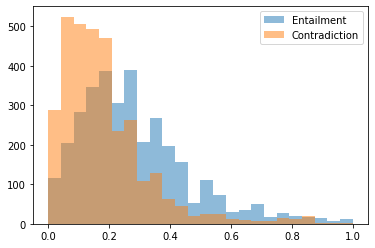

In [49]:
bins = np.linspace(0.0, 1.0, 25)
labels = np.array(snli[subset]['label'])
ent_jaccards = jaccards[labels == 0]
cont_jaccards = jaccards[labels == 2]
plt.hist(ent_jaccards, bins, alpha=0.5, label="Entailment")
plt.hist(cont_jaccards, bins, alpha=0.5, label="Contradiction")
plt.legend()
plt.show()

In [54]:
len(snli[subset])

10000

In [55]:
num_samples=1000

In [56]:
top_indices = np.argsort(jaccards)[-num_samples:]

In [57]:
jaccards[top_indices[0]] # Cut rate

0.4375

In [58]:
np.mean(labels[top_indices] == 0) # 

0.545

In [60]:
def find_high_lex_overlap_idxs(dataset, count_lim=400):
    jaccards = []
    labels = np.array(dataset['label'])
    for sample in dataset:
        hyposet = set(word_tokenize(sample['hypothesis'].lower())) - puncts
        premset = set(word_tokenize(sample['premise'].lower())) - puncts
        jaccards.append(jaccard_similarity(hyposet, premset))
    jaccards = np.array(jaccards)
    top_indices = np.argsort(jaccards)[-count_lim:]
    ent_indices = top_indices[labels[top_indices] == 0]
    cont_indices = top_indices[labels[top_indices] == 2]
    return ent_indices, cont_indices

In [62]:
train_ents, train_conts = find_high_lex_overlap_idxs(snli["train"], count_lim=60000)
val_ents, val_conts = find_high_lex_overlap_idxs(snli["validation"], count_lim=1000)
test_ents, test_conts = find_high_lex_overlap_idxs(snli["test"], count_lim=1000)

In [63]:
test_ents[0]

9872

In [64]:
snli['test'][int(test_ents[0])], snli['test'][int(test_conts[0])]

({'premise': 'A bearded man sits near a white van.',
  'hypothesis': 'a man sitting outside near a van.',
  'label': 0},
 {'premise': 'A nighttime street scene of a restaurant.',
  'hypothesis': 'A nighttime scene of an apartment building.',
  'label': 2})

In [66]:
all_indices = {"train_ents" : list(train_ents), "train_conts" : list(train_conts), "val_ents" : list(val_ents), "val_conts" : list(val_conts), "test_ents" : list(test_ents), "test_conts" : list(test_conts)}

In [68]:
for key, value in all_indices.items():
    print(key)
    print(len(value))

train_ents
30805
train_conts
11118
val_ents
545
val_conts
170
test_ents
571
test_conts
156


In [69]:
import numpy
import json

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.integer):
            return int(obj)
        elif isinstance(obj, numpy.floating):
            return float(obj)
        elif isinstance(obj, numpy.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [71]:
with open("/home/meissner/shortcut-pruning/data/subsets/snli_lex_overlap_indices.json", "w") as _file:
    _file.write(json.dumps(all_indices, cls=MyEncoder))